In [88]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from matplotlib_venn import venn2, venn2_circles, venn2_unweighted
from matplotlib_venn import venn3, venn3_circles
import glob
import warnings
warnings.filterwarnings('ignore')

# The ionbot result files
The content of the result files is described [here](https://ionbot.cloud/help).
## Dataset PXD000561

In [89]:
srdf = pd.read_csv("PXD000561/sdrf.tsv", sep="\t")

In [90]:
srdf[0:24] 

,source name,characteristics[organism],characteristics[organism part],characteristics[age],characteristics[developmental stage],characteristics[sex],characteristics[disease],characteristics[cell type],characteristics[ancestry category],characteristics[age].1,...,comment[cleavage agent details],comment[dissociation method],comment[collision energy],comment[precursor mass tolerance],comment[fragment mass tolerance],comment[data file],Material Type,factor value[organism part],sampleChecksum,sampleAccession
0,PXD000561-Sample 1,Homo sapiens,adrenal gland,not available,Adult,not available,not available,not applicable,not available,not available,...,AC=MS:1001251;NT=Trypsin,AC=MS:1000422;NT=HCD,not available,10 ppm,0.05 Da,Adult_Adrenalgland_bRP_Velos_1_f01.raw,organism part,Adrenal gland,87c002c98bc9adab8660a4a7ac9cdd3d18e71521fe69e5...,SAMEA7711132
1,PXD000561-Sample 1,Homo sapiens,adrenal gland,not available,Adult,not available,not available,not applicable,not available,not available,...,AC=MS:1001251;NT=Trypsin,AC=MS:1000422;NT=HCD,not available,10 ppm,0.05 Da,Adult_Adrenalgland_bRP_Velos_1_f02.raw,organism part,Adrenal gland,87c002c98bc9adab8660a4a7ac9cdd3d18e71521fe69e5...,SAMEA7711132
2,PXD000561-Sample 1,Homo sapiens,adrenal gland,not available,Adult,not available,not available,not applicable,not available,not available,...,AC=MS:1001251;NT=Trypsin,AC=MS:1000422;NT=HCD,not available,10 ppm,0.05 Da,Adult_Adrenalgland_bRP_Velos_1_f03.raw,organism part,Adrenal gland,87c002c98bc9adab8660a4a7ac9cdd3d18e71521fe69e5...,SAMEA7711132
3,PXD000561-Sample 1,Homo sapiens,adrenal gland,not available,Adult,not available,not available,not applicable,not available,not available,...,AC=MS:1001251;NT=Trypsin,AC=MS:1000422;NT=HCD,not available,10 ppm,0.05 Da,Adult_Adrenalgland_bRP_Velos_1_f04.raw,organism part,Adrenal gland,87c002c98bc9adab8660a4a7ac9cdd3d18e71521fe69e5...,SAMEA7711132
4,PXD000561-Sample 1,Homo sapiens,adrenal gland,not available,Adult,not available,not available,not applicable,not available,not available,...,AC=MS:1001251;NT=Trypsin,AC=MS:1000422;NT=HCD,not available,10 ppm,0.05 Da,Adult_Adrenalgland_bRP_Velos_1_f05.raw,organism part,Adrenal gland,87c002c98bc9adab8660a4a7ac9cdd3d18e71521fe69e5...,SAMEA7711132
5,PXD000561-Sample 1,Homo sapiens,adrenal gland,not available,Adult,not available,not available,not applicable,not available,not available,...,AC=MS:1001251;NT=Trypsin,AC=MS:1000422;NT=HCD,not available,10 ppm,0.05 Da,Adult_Adrenalgland_bRP_Velos_1_f06.raw,organism part,Adrenal gland,87c002c98bc9adab8660a4a7ac9cdd3d18e71521fe69e5...,SAMEA7711132
6,PXD000561-Sample 1,Homo sapiens,adrenal gland,not available,Adult,not available,not available,not applicable,not available,not available,...,AC=MS:1001251;NT=Trypsin,AC=MS:1000422;NT=HCD,not available,10 ppm,0.05 Da,Adult_Adrenalgland_bRP_Velos_1_f07.raw,organism part,Adrenal gland,87c002c98bc9adab8660a4a7ac9cdd3d18e71521fe69e5...,SAMEA7711132
7,PXD000561-Sample 1,Homo sapiens,adrenal gland,not available,Adult,not available,not available,not applicable,not available,not available,...,AC=MS:1001251;NT=Trypsin,AC=MS:1000422;NT=HCD,not available,10 ppm,0.05 Da,Adult_Adrenalgland_bRP_Velos_1_f08.raw,organism part,Adrenal gland,87c002c98bc9adab8660a4a7ac9cdd3d18e71521fe69e5...,SAMEA7711132
8,PXD000561-Sample 1,Homo sapiens,adrenal gland,not available,Adult,not available,not available,not applicable,not available,not available,...,AC=MS:1001251;NT=Trypsin,AC=MS:1000422;NT=HCD,not available,10 ppm,0.05 Da,Adult_Adrenalgland_bRP_Velos_1_f09.raw,organism part,Adrenal gland,87c002c98bc9adab8660a4a7ac9cdd3d18e71521fe69e5...,SAMEA7711132
9,PXD000561-Sample 1,Homo sapiens,adrenal gland,not available,Adult,not available,not available,not applicable,not available,not available,...,AC=MS:1001251;NT=Trypsin,AC=MS:1000422;NT=HCD,not available,10 ppm,0.05 Da,Adult_Adrenalgland_bRP_Velos_1_f10.raw,organism part,Adrenal gland,87c002c98bc9adab8660a4a7ac9cdd3d18e71521fe69e5...,SAMEA7711132


From sample 1 to 24, the samples are fractions from adults and from adrenal gland. There is no difference so we can concat results from each pre-processing method.

### 1) Non-processed

In [91]:
result_folder = "/home/tribiosis/Master/master_thesis/ionbot/PXD000561/non-processed/"

#### Peptide level results

First, we load the result file that contains the first ranked matches for each MS2 spectrum:

In [92]:
# Concatenate "ionbot.first" results from every fraction
fractions = [i for i in glob.glob(result_folder+"f*")]
ionbot = pd.read_csv(fractions[0] + "/ionbot.first.csv")
for fraction in fractions:
    ionbot = pd.concat([ionbot, pd.read_csv(fraction + "/ionbot.first.csv")])

The column `database` is `T` if the PSM matched the target database, it is `D` otherwise.

We can see that the result file contains all matches with FDR<1%:

In [93]:
print(ionbot["database"].value_counts())

T    284810
D      2790
Name: database, dtype: int64


The column `psm_score` contains the SVM (Percolator 3.0) score (i.e. the PSM score) for the matched spectra:

Next, we load the result file that contains the lower ranked (co-eluting) matches for each MS2 spectrum and add these to the search results:

In [94]:
# Concatenate "ionbot.lower" results from every fraction
tmp = pd.read_csv(fractions[0] + "/ionbot.lower.csv")
for fraction in fractions:
    tmp = pd.concat([tmp, pd.read_csv(fraction + "/ionbot.lower.csv")])

In [95]:
ionbot["rank"] = ["first"]*len(ionbot)
tmp["rank"] = ["lower"]*len(tmp)
ionbot = pd.concat([ionbot,tmp])

In [96]:
# we remove the matches against the decoy database:
ionbot = ionbot[(ionbot["database"]=="T")]

In [97]:
# Because there are spectrum titles repeated from mgf file to mgf file (fractions).
def unique_spectrum_id(scan, file):
    file_extension = file.split("_")[5][0:3]
    ID = str(scan) + file_extension
    return ID

In [98]:
ionbot['spec_ID'] = ionbot.apply(lambda row : unique_spectrum_id(row["scan"], row["spectrum_file"]), axis = 1)
n_spectra_nonprocessed = len(ionbot["spec_ID"].unique())

Now we generated an unique spectrum ID. 
In order to analyze the number of PSMs we concatenate the spec ID to the peptide sequence. 
BEcause the same spectrum can match to different peptides at a FDR<0.01.
In order to evaluate the effect of the prepro method on the modifications found, we do another procedure, where
we concat specID-peptide-modification. Because a spectrum can match to the same peptide with different 
modifications. Therefore, we account for different peptidoforms.

In [99]:
# There are several PSM per spectrum and also exact duplicates
ionbot = ionbot.drop_duplicates(subset=["ionbot_match_id", "spec_ID","matched_peptide", "modifications_delta", "psm_score"])

In [100]:
def unique_PSM(ID, peptide):
    PSM = ID +","+ peptide
    return PSM

In [101]:
ionbot['PSM_ID'] = ionbot.apply(lambda row : unique_PSM(row["spec_ID"], row["matched_peptide"]), axis = 1)

In [102]:
PSM_nonprocessed = ionbot["PSM_ID"].unique()
n_PSM_nonprocessed = len(ionbot["PSM_ID"].unique())

In [103]:
def unique_peptidoform(peptide, mods):
    if str(mods)=="nan":
        pepform = peptide
    else:
        pepform = peptide + str(mods)
    return pepform

In [104]:
ionbot['peptidoform'] = ionbot.apply(lambda row : unique_peptidoform(row["matched_peptide"], row["modifications"]), axis = 1)
peptform_nonprocessed = ionbot["peptidoform"].unique()
n_peptform_nonprocessed = len(ionbot["peptidoform"].unique())

In [105]:
def unique_PSM_peptidoform(PSM, mods):
    if str(mods) == "nan":
        PSMpeptform = PSM
    else:
        PSMpeptform = PSM + str(mods)
    return PSMpeptform

In [106]:
ionbot['PSM_peptidoform'] = ionbot.apply(lambda row : unique_PSM_peptidoform(row["PSM_ID"], row["modifications"]), axis = 1)

In [107]:
PSM_peptform_nonprocessed = ionbot["PSM_peptidoform"].unique()
n_PSM_peptform_nonprocessed = len(ionbot["PSM_peptidoform"].unique())

In [108]:
def extract_peptides(df):
    peptide_list = []
    for peptide in df["matched_peptide"].unique():
        peptide_list.append(peptide)
    return peptide_list

In [109]:
peptides_nonprocessed = extract_peptides(ionbot)
n_peptides_nonprocessed = len(peptides_nonprocessed)

#### Protein level results

In [110]:
# Concatenate "ionbot.proteins.first" results from every fraction
fractions = [i for i in glob.glob(result_folder+"f*")]
proteins= pd.read_csv(fractions[0] + "/ionbot.first.proteins.csv")
for fraction in fractions:
    proteins= pd.concat([proteins, pd.read_csv(fraction + "/ionbot.first.proteins.csv")])

# Concatenate "ionbot.coeluting.proteins.csv" results from every fraction
tmp = pd.read_csv(fractions[0] + "/ionbot.coeluting.proteins.csv")
for fraction in fractions:
    tmp = pd.concat([tmp, pd.read_csv(fraction + "/ionbot.coeluting.proteins.csv")])

proteins["rank"] = ["first"]*len(proteins)
tmp["rank"] = ["lower"]*len(tmp)
proteins= pd.concat([proteins,tmp])

proteins_nonprocessed = proteins["uniprot_id"].unique()
n_proteins_nonprocessed = len(proteins_nonprocessed) 

### 2) Precursor ion removed at 0.01 Da mass tolerance

In [111]:
# Integrate all done before in a function

def extract_ionbot_results(result_folder):
    # Concatenate "ionbot.first" results from every fraction
    fractions = [i for i in glob.glob(result_folder+"*")]
    ionbot2 = pd.read_csv(fractions[0] + "/ionbot.first.csv")
    for fraction in fractions:
        ionbot2 = pd.concat([ionbot2, pd.read_csv(fraction + "/ionbot.first.csv")])
    # Concatenate "ionbot.lower" results from every fraction
    tmp = pd.read_csv(fractions[0] + "/ionbot.lower.csv")
    for fraction in fractions:
        tmp = pd.concat([tmp, pd.read_csv(fraction + "/ionbot.lower.csv")])
    ionbot2["rank"] = ["first"]*len(ionbot2)
    tmp["rank"] = ["lower"]*len(tmp)
    ionbot2 = pd.concat([ionbot2,tmp])
    ionbot2 = ionbot2[(ionbot2["database"]=="T")]   
    ionbot2['spec_ID'] = ionbot2.apply(lambda row : unique_spectrum_id(row["scan"], row["spectrum_file"]), axis = 1)
    n_spectra_precrem001 = len(ionbot2["spec_ID"].unique())
    ionbot2 = ionbot2.drop_duplicates(subset=["ionbot_match_id", "spec_ID","matched_peptide", "modifications_delta", "psm_score"])
    ionbot2['PSM_ID'] = ionbot2.apply(lambda row : unique_PSM(row["spec_ID"], row["matched_peptide"]), axis = 1)
    PSM_precrem001 = ionbot2["PSM_ID"].unique()
    n_PSM_precrem001 = len(PSM_precrem001)

    ionbot2['peptidoform'] = ionbot2.apply(lambda row : unique_peptidoform(row["matched_peptide"], row["modifications"]), axis = 1)
    peptform_precrem001 = ionbot2["peptidoform"].unique()
    n_peptform_precrem001 = len(ionbot2["peptidoform"].unique())

    ionbot2['PSM_peptidoform'] = ionbot2.apply(lambda row : unique_PSM_peptidoform(row["PSM_ID"], row["modifications"]), axis = 1)
    PSM_peptform_precrem001 = ionbot2["PSM_peptidoform"].unique()
    n_PSM_peptform_precrem001 = len(ionbot2["PSM_peptidoform"].unique())
    peptides_precrem001 = extract_peptides(ionbot2)
    n_peptides_precrem001 = len(peptides_precrem001)
    # Concatenate "ionbot.proteins.first" results from every fraction
    fractions = [i for i in glob.glob(result_folder+"*")]
    proteins2= pd.read_csv(fractions[0] + "/ionbot.first.proteins.csv")
    for fraction in fractions:
        proteins2= pd.concat([proteins2, pd.read_csv(fraction + "/ionbot.first.proteins.csv")])

    # Concatenate "ionbot.coeluting.proteins.csv" results from every fraction
    tmp = pd.read_csv(fractions[0] + "/ionbot.coeluting.proteins.csv")
    for fraction in fractions:
        tmp = pd.concat([tmp, pd.read_csv(fraction + "/ionbot.coeluting.proteins.csv")])

    proteins2["rank"] = ["first"]*len(proteins2)
    tmp["rank"] = ["lower"]*len(tmp)
    proteins2= pd.concat([proteins2,tmp])

    proteins_precrem001 = proteins2["uniprot_id"].unique()
    n_proteins_precrem001 = len(proteins_precrem001)
    return ionbot2, n_spectra_precrem001, PSM_precrem001, n_PSM_precrem001, peptform_precrem001, n_peptform_precrem001, PSM_peptform_precrem001, n_PSM_peptform_precrem001, peptides_precrem001, n_peptides_precrem001,proteins_precrem001, n_proteins_precrem001 

In [112]:
result_folder = "/home/tribiosis/Master/master_thesis/ionbot/PXD000561/precrem_01/"
ionbot2, n_spectra_precrem001, PSM_precrem001, n_PSM_precrem001, peptform_precrem001, n_peptform_precrem001, PSM_peptform_precrem001, n_PSM_peptform_precrem001, peptides_precrem001, n_peptides_precrem001,proteins_precrem001, n_proteins_precrem001 = extract_ionbot_results(result_folder)

### 3) Precursor ion removed at 0.02 Da mass tolerance

In [113]:
result_folder = "/home/tribiosis/Master/master_thesis/ionbot/PXD000561/precrem_02/"
ionbot3, n_spectra_precrem002, PSM_precrem002, n_PSM_precrem002, peptform_precrem002, n_peptform_precrem002, PSM_peptform_precrem002, n_PSM_peptform_precrem002, peptides_precrem002, n_peptides_precrem002,proteins_precrem002, n_proteins_precrem002 = extract_ionbot_results(result_folder)

### 4) Precursor ion removed at 0.05 Da mass tolerance

In [114]:
result_folder = "/home/tribiosis/Master/master_thesis/ionbot/PXD000561/precrem_05/"
ionbot4, n_spectra_precrem005, PSM_precrem005, n_PSM_precrem005, peptform_precrem005, n_peptform_precrem005, PSM_peptform_precrem005, n_PSM_peptform_precrem005, peptides_precrem005, n_peptides_precrem005,proteins_precrem005, n_proteins_precrem005 = extract_ionbot_results(result_folder)

### 5) Rank TIC normalized

In [115]:
result_folder = "/home/tribiosis/Master/master_thesis/ionbot/PXD000561/rankTIC/"
ionbot5, n_spectra_rankTIC, PSM_rankTIC, n_PSM_rankTIC, peptform_rankTIC, n_peptform_rankTIC, PSM_peptform_rankTIC, n_PSM_peptform_rankTIC, peptides_rankTIC, n_peptides_rankTIC, proteins_rankTIC, n_proteins_rankTIC = extract_ionbot_results(result_folder) 

### 6) Rank highest peak normalized

In [116]:
result_folder = "/home/tribiosis/Master/master_thesis/ionbot/PXD000561/rankhighest/"
ionbot6, n_spectra_rankhighest, PSM_rankhighest, n_PSM_rankhighest, peptform_rankhighest, n_peptform_rankhighest, PSM_peptform_rankhighest, n_PSM_peptform_rankhighest, peptides_rankhighest, n_peptides_rankhighest, proteins_rankhighest, n_proteins_rankhighest = extract_ionbot_results(result_folder) 

### 7) Precursor removed 0.02 Da + Rank TIC normalization

In [117]:
result_folder = "/home/tribiosis/Master/master_thesis/ionbot/PXD000561/precrem_rankTIC/"
ionbot7, n_spectra_precrem_rankTIC, PSM_precrem_rankTIC, n_PSM_precrem_rankTIC, peptform_precrem_rankTIC, n_peptform_precrem_rankTIC, PSM_peptform_precrem_rankTIC, n_PSM_peptform_precrem_rankTIC, peptides_precrem_rankTIC, n_peptides_precrem_rankTIC, proteins_precrem_rankTIC, n_proteins_precrem_rankTIC = extract_ionbot_results(result_folder) 

### 8)TIC normalization

In [118]:
result_folder = "/home/tribiosis/Master/master_thesis/ionbot/PXD000561/TIC/"
ionbot8, n_spectra_TIC, PSM_TIC, n_PSM_TIC, peptform_TIC, n_peptform_TIC, PSM_peptform_TIC, n_PSM_peptform_TIC, peptides_TIC, n_peptides_TIC, proteins_TIC, n_proteins_TIC = extract_ionbot_results(result_folder) 

### Venn's diagrams

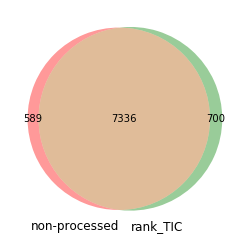

In [119]:
# Protein level
venn_np_rank_norm = venn2(subsets= (set(proteins_nonprocessed), set(proteins_rankTIC)), set_labels =("non-processed","rank_TIC"))

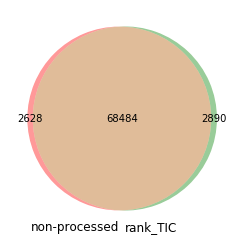

In [120]:
# Peptide level
venn_np_rank_norm = venn2(subsets= (set(peptides_nonprocessed), set(peptides_rankTIC)), set_labels =("non-processed","rank_TIC"))

### Spectra level

In [121]:
df = pd.DataFrame()
df["method"] = ["non processed", "precursor removed 0.01 Da", "precursor removed 0.02 Da", "precursor removed 0.05 Da", "rank-TIC norm", "rank highest peak norm", "precursor removed + rank-TIC"]
df["# spectra"] = [n_spectra_nonprocessed,n_spectra_precrem001, n_spectra_precrem002, n_spectra_precrem005, n_spectra_rankTIC, n_spectra_rankhighest, n_spectra_precrem_rankTIC]

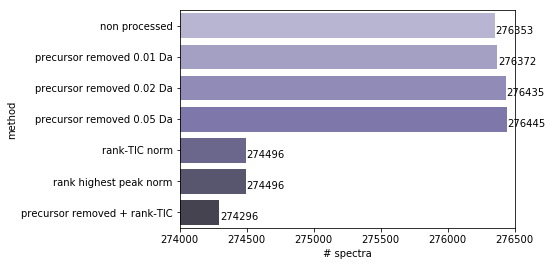

In [122]:
pal = sns.color_palette("Purples_d", len(df))

ax = sns.barplot(x="# spectra",y="method", data=df, palette=pal)

plt.xlim(274000,276500)
for i, v in enumerate(df["# spectra"]):
    ax.text(v + 3, i + .25, str(v), color='black')
plt.show()

### Protein level

In [123]:
df = pd.DataFrame()
df["method"] = ["non processed", "precursor removed 0.01 Da", "precursor removed 0.02 Da", "precursor removed 0.05 Da", "rank-TIC norm", "rank highest peak norm", "precursor removed + rank-TIC"]
df["# proteins"] = [n_proteins_nonprocessed,n_proteins_precrem001, n_proteins_precrem002, n_proteins_precrem005, n_proteins_rankTIC, n_proteins_rankhighest, n_proteins_precrem_rankTIC]

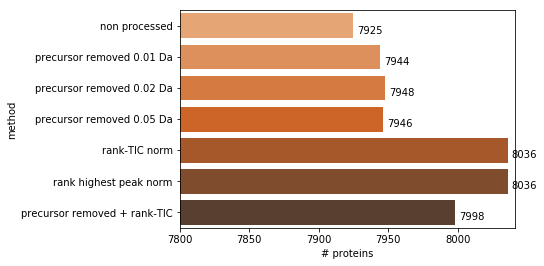

In [124]:
pal = sns.color_palette("Oranges_d", len(df))

ax = sns.barplot(x="# proteins",y="method", data=df, palette=pal)

plt.xlim(7800,n_proteins_rankhighest+5)

for i, v in enumerate(df["# proteins"]):
    ax.text(v + 3, i + .25, str(v), color='black')
plt.show()

In [125]:
from upsetplot import from_memberships
from upsetplot import UpSet
from upsetplot import generate_counts, plot

In [126]:
def list_to_str(lst):
    return ",".join(lst)

In [127]:
# Create Data format for upset plot package
def data_to_upset_format(sets, methods):
    i = 0
    upset_df = pd.DataFrame()
    rowIndex = 0
    for df in sets:
        method = methods[i]
        i += 1
        for protein in df:
            if protein not in upset_df.columns:
                upset_df.loc[rowIndex, protein] = [[method]]
            else:
                upset_df[protein][0].append(method)

    upset_df = upset_df.append(upset_df.iloc[0])   
    upset_df.iloc[0] = upset_df.columns 
    upset_df.index = ["proteins", "methods"]
    upset_df.columns = range(upset_df.shape[1])
    upset_df = upset_df.T
    upset_df["methods"]= upset_df.apply(lambda row : list_to_str(row["methods"]), axis = 1)
    sets_by_method = from_memberships(upset_df.methods.str.split(','), data=upset_df)
    return sets_by_method

In [128]:
sets = [proteins_nonprocessed, proteins_precrem001, proteins_precrem002, proteins_precrem005]
methods = ["non processed", "precursor removed 0.01 Da", "precursor removed 0.02 Da", "precursor removed 0.05 Da"]
prots_by_method = data_to_upset_format(sets, methods)

<Figure size 720x216 with 0 Axes>

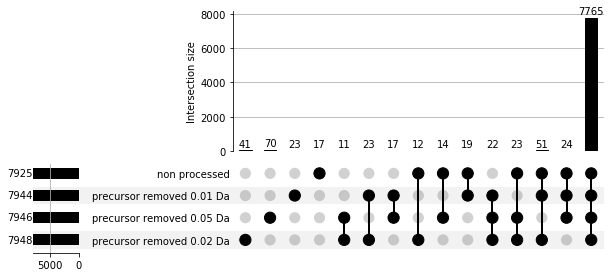

In [129]:
fig = plt.figure(figsize=(10, 3))

UpSet(prots_by_method, show_counts=True)

From non-processed to removing the precursor at 0.02 Da, the number of proteins increase in a 0.3 %

In [130]:
# Create Data format for upset plot package
sets = [proteins_nonprocessed, proteins_rankTIC, proteins_rankhighest, proteins_precrem_rankTIC]
methods = ["non processed","rank-TIC norm", "rank highest peak norm", "precursor removed + rank TIC norm"]
prots_by_method2 = data_to_upset_format(sets, methods)

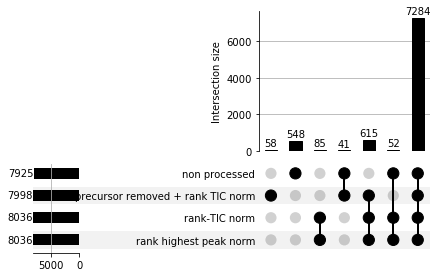

In [131]:
UpSet(prots_by_method2, show_counts=True)

Both rank-TIC and rank-highest peak normalization give the same results. With these methods 111 proteins more are identified compared with the non processed data, which is a 1.4 % more of proteins identified.
615 proteins are only identified with the 3 normalization methods (not with the non processed data). However, 548 are uniquely identified when not applying a normalization method.

### Peptide level

In [132]:
df = pd.DataFrame()
df["method"] = ["non processed", "precursor removed 0.01 Da", "precursor removed 0.02 Da", "precursor removed 0.05 Da", "rank-TIC norm", "rank highest peak norm", "precursor removed + rank-TIC"]
df["# peptides"] = [n_peptides_nonprocessed,n_peptides_precrem001, n_peptides_precrem002, n_peptides_precrem005, n_peptides_rankTIC, n_peptides_rankhighest, n_peptides_precrem_rankTIC]

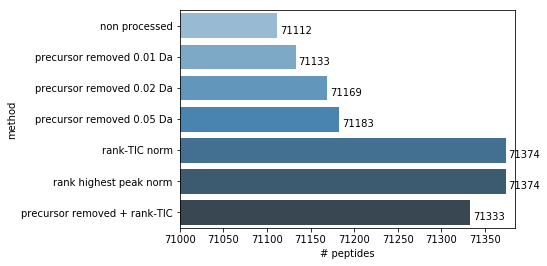

In [133]:
pal = sns.color_palette("Blues_d", len(df))

ax = sns.barplot(x="# peptides",y="method", data=df, palette=pal)

plt.xlim(71000,n_peptides_rankTIC+10)
for i, v in enumerate(df["# peptides"]):
    ax.text(v + 3, i + .25, str(v), color='black')
plt.show()

###  Peptidoform level

In [134]:
df = pd.DataFrame()
df["method"] = ["non processed", "precursor removed 0.01 Da", "precursor removed 0.02 Da", "precursor removed 0.05 Da", "rank-TIC norm", "rank highest peak norm", "precursor removed + rank-TIC"]
df["# peptidoform"] = [n_peptform_nonprocessed,n_peptform_precrem001, n_peptform_precrem002, n_peptform_precrem005, n_peptform_rankTIC, n_peptform_rankhighest, n_peptform_precrem_rankTIC]

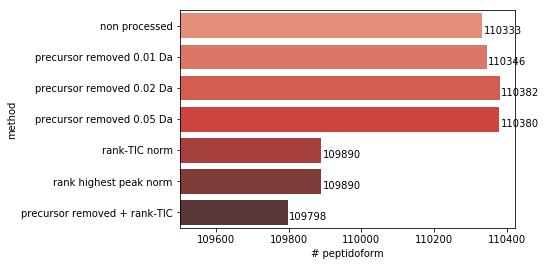

In [135]:
pal = sns.color_palette("Reds_d", len(df))

ax = sns.barplot(x="# peptidoform",y="method", data=df, palette=pal)

plt.xlim(109500,n_peptform_precrem002+40)
for i, v in enumerate(df["# peptidoform"]):
    ax.text(v + 3, i + .25, str(v), color='black')
plt.show()

### Peptide to spectrum match level

In [136]:
df = pd.DataFrame()
df["method"] = ["non processed", "precursor removed 0.01 Da", "precursor removed 0.02 Da", "precursor removed 0.05 Da", "rank TIC norm", "rank highest peak norm", "precursor removed + rankTIC norm"]
df["# PSM"] = [n_PSM_nonprocessed,n_PSM_precrem001, n_PSM_precrem002, n_PSM_precrem005, n_PSM_rankTIC, n_PSM_rankhighest, n_PSM_precrem_rankTIC]

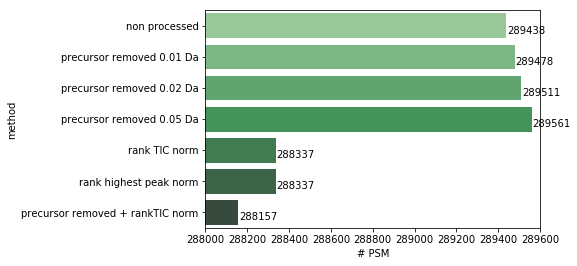

In [137]:
pal = sns.color_palette("Greens_d", len(df))

ax = sns.barplot(x="# PSM",y="method", data=df, palette=pal)

plt.xlim(288000,n_PSM_precrem005+40)
for i, v in enumerate(df["# PSM"]):
    ax.text(v + 3, i + .25, str(v), color='black')
plt.show()

### Peptidoform to spectrum match level

In [138]:
df = pd.DataFrame()
df["method"] = ["non processed", "precursor removed 0.01 Da", "precursor removed 0.02 Da", "precursor removed 0.05 Da", "rank TIC norm", "rank highest peak norm", "precursor removed + rankTIC"]
df["# peptidoformSM"] = [n_PSM_peptform_nonprocessed,n_PSM_peptform_precrem001, n_PSM_peptform_precrem002, n_PSM_peptform_precrem005, n_PSM_peptform_rankTIC, n_PSM_peptform_rankhighest, n_PSM_peptform_precrem_rankTIC]

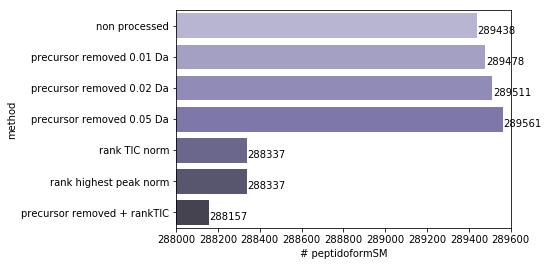

In [139]:
pal = sns.color_palette("Purples_d", len(df))

ax = sns.barplot(x="# peptidoformSM",y="method", data=df, palette=pal)

plt.xlim(288000,n_PSM_peptform_precrem005+40)
for i, v in enumerate(df["# peptidoformSM"]):
    ax.text(v + 3, i + .25, str(v), color='black')
plt.show()

### TIC normalization analysis

In [140]:
df = pd.DataFrame()
df["ionbot metric"] = ["# spectra", "# spectra", "# PSM", "# PSM", "# peptides", "# peptides", "# peptidoforms", "# peptidoforms", "# proteins", "# proteins"]
df["number"] = [n_spectra_nonprocessed, n_spectra_TIC, n_PSM_peptform_nonprocessed, n_PSM_peptform_TIC, n_peptides_nonprocessed, n_peptides_TIC, n_peptform_nonprocessed, n_peptform_TIC, n_proteins_nonprocessed, n_proteins_TIC]
df["method"] = ["non processed", "TIC normalized", "non processed", "TIC normalized","non processed", "TIC normalized", "non processed", "TIC normalized", "non processed", "TIC normalized"]

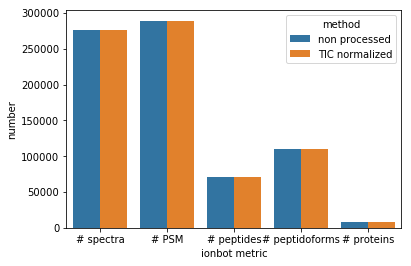

In [141]:
sns.barplot(x="ionbot metric", y = "number", hue="method", data=df)


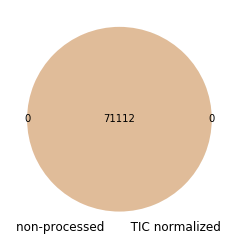

In [142]:
# Peptide level
venn_np_rank_norm = venn2(subsets= (set(peptides_nonprocessed), set(peptides_precrem_TIC)), set_labels =("non-processed    ","   TIC normalized"))

### q-value distribution

In [143]:
def create_df_qvalue_densityplot(ionbot,method):
    df = pd.DataFrame(columns=["q-value","method"])
    df["q-value"] = ionbot["q-value"]
    df["method"] = method
    return df

In [144]:
densityplot_df = create_df_qvalue_densityplot(ionbot,"non processed")
methods = ["precursor removed 0.01 Da", "precursor removed 0.02 Da", "precursor removed 0.05 Da", "rank TIC norm", "rank highest peak norm", "precursor removed 0.02Da + rank-TIC"]
ionbot_dfs = [ ionbot2, ionbot3, ionbot4, ionbot5, ionbot6, ionbot7]
for i,method in enumerate(methods):
    densityplot_df = pd.concat([densityplot_df, create_df_qvalue_densityplot(ionbot_dfs[i],method)])

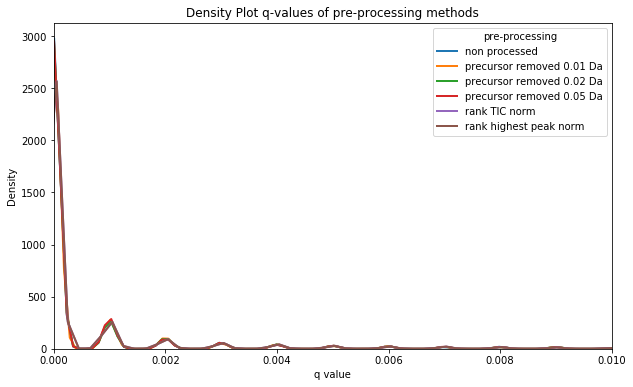

In [145]:
# List of 7 pre-processing settings/methods
plt.figure(figsize=(10,6))
methods = ["non processed", "precursor removed 0.01 Da", "precursor removed 0.02 Da", "precursor removed 0.05 Da", "rank TIC norm", "rank highest peak norm"]

# Iterate through the methods
for method in methods:
    # Subset to the method
    subset = densityplot_df[densityplot_df['method'] == method]
    
    # Draw the density plot
    sns.distplot(subset['q-value'], hist = False, kde = True,
                 kde_kws = {'shade': False, 'linewidth': 2},
                 label = method)
    
# Plot formatting
plt.legend(title = 'pre-processing')
plt.title('Density Plot q-values of pre-processing methods')
plt.xlabel('q value')
plt.ylabel('Density')
plt.xlim(0,0.01)
plt.show()


### Analize q-value distribution by ratio subsets
Create subsets of spectra titles taking into account their intensity removed ratios (hen removing the precursor at 0.02 Da) 
- Subset 1 ratio < 0.25
- Subset 2 ratios from 0.25 to 0.5
- Subset 3 ratios 0.5 to 0.75
- Subset 4 ratios > 0.75

I created a function that stores the title name of the spectrum in a different list depending on the ratio value (highest peak and TIC ratios). Then it writes in a different line the names for each of the 8 subsets (4 and 4). The following functions extract the spectra name and store them in each subset.

In [146]:
def extract_TIC_subsets(file):
    f = open(file)
    i = 0
    for line in f:
        i+=1
        if i == 1:
            subset1 = [value.strip() for value in line.split(",")[:-1]]
        if i == 2:
            subset2 = [value.strip() for value in line.split(",")[:-1]]
        if i == 3:
            subset3 = [value.strip() for value in line.split(",")[:-1]]
        if i == 4:
            subset4 = [value.strip() for value in line.split(",")[:-1]]            
    return [subset1, subset2, subset3, subset4]

In [147]:
def extract_highestpeak_subsets(file):
    f = open(file)
    i = 0
    for line in f:
        i+=1
        if i == 5:
            subset1 = [value.strip() for value in line.split(",")[:-1]]
        if i == 6:
            subset2 = [value.strip() for value in line.split(",")[:-1]]
        if i == 7:
            subset3 = [value.strip() for value in line.split(",")[:-1]]
        if i == 8:
            subset4 = [value.strip() for value in line.split(",")[:-1]]            
    return [subset1, subset2, subset3, subset4]

As we have spectra names repeated between files/fraction, we create a dataframe with a column for the fraction/file and the 8 subsets. So in each line we store the spectra names list for the 8 subsets for each of the files. We reate dataframe with subset results from every fraction


In [148]:
# Initialize dataframe 
files = [i for i in glob.glob("PXD000561/*data.txt")]
file_fraction = files[0].split("/")[-1].split("_")[5] 
TIC_subs = extract_TIC_subsets(files[0])
high_subs = extract_highestpeak_subsets(files[0])
subsets_df = pd.DataFrame(data={"fraction":file_fraction,"subset1": [TIC_subs[0]],"subset2":[TIC_subs[1]], "subset3": [TIC_subs[2]], "subset4": [TIC_subs[3]],
              "subset1_high":[high_subs[0]], "subset2_high":[high_subs[1]],"subset3_high":[high_subs[2]],"subset4_high":[high_subs[3]]})

# Add a new row for each of the fractions/files
for file in files[1:]:
    file_fraction = file.split("/")[-1].split("_")[5]
    TIC_subs = extract_TIC_subsets(file)
    high_subs = extract_highestpeak_subsets(file)

    new_row = pd.DataFrame(data={"fraction":file_fraction,"subset1": [TIC_subs[0]],"subset2":[TIC_subs[1]], "subset3": [TIC_subs[2]], "subset4": [TIC_subs[3]],
              "subset1_high":[high_subs[0]], "subset2_high":[high_subs[1]],"subset3_high":[high_subs[2]],"subset4_high":[high_subs[3]]})
    subsets_df = pd.concat([subsets_df,new_row], axis=0)

In [149]:
subsets_df = subsets_df.reset_index()

In "subsets_df" we have each spectrum assigned to one of the 4 TIC ratio subsets and to one of the highespeak ratio subsets. Now we want to iterate over ionbot results, where all the significant PSM scores are stored.
And depending on from which spectrum is the score, add it to one of the correspondent subsets. Thus, if the first score is from a spectrum that was in the first TIC ratio subset, the score will be added to "TIC_scores1".

In [150]:
TIC_scores1 = []
TIC_scores2 = []
TIC_scores3 = [] 
TIC_scores4 = []

for index, row in ionbot.iterrows():                                  # iterate over rows in ionbot result dataframe
    fraction = row["spectrum_file"].split("_")[5][0:3]                   # extract the fraction/file
    title = row["spectrum_title"].strip()                                 # exract spectrum title
    fraction_subsets = subsets_df.loc[subsets_df['fraction'] == fraction]  # extract subsets of that fraction
    for i, subset in enumerate(fraction_subsets.columns[2:6]): #check in which TIC subset is the spectra
        if title in list(fraction_subsets[subset])[0]:        # when found
            if i == 0:                                            # add its PSM score to the correspondent subset
                TIC_scores1.append(row["q-value"])
            if i == 1:                                      
                TIC_scores2.append(row["q-value"]) 
            if i == 2:                                     
                TIC_scores3.append(row["q-value"])
            if i == 3:                                    
                TIC_scores4.append(row["q-value"])
                    
list_PSMscores_TICsubset_non_process = [TIC_scores1, TIC_scores2, TIC_scores3, TIC_scores4]    

In [151]:
def qvalues_subsets_TICratio(ionbot_df, subset_df):
    TIC_scores1 = []
    TIC_scores2 = []
    TIC_scores3 = [] 
    TIC_scores4 = []

    for index, row in ionbot_df.iterrows():                        # iterate over rows in ionbot result dataframe
        fraction = row["spectrum_file"].split("_")[5][0:3]                   # extract the fraction/file
        title = row["spectrum_title"].strip()                                 # exract spectrum title
        fraction_subsets = subset_df.loc[subset_df['fraction'] == fraction]  # extract subsets of that fraction
        for i, subset in enumerate(fraction_subsets.columns[2:6]):       #check in which TIC subset is the spectra
            if len(fraction_subsets[subset]) == 0:
                next
            if title in list(fraction_subsets[subset])[0]:        # when found
                if i == 0:                                          # add its PSM score to the correspondent subset
                    TIC_scores1.append(row["q-value"])
                if i == 1:                                      
                    TIC_scores2.append(row["q-value"]) 
                if i == 2:                                     
                    TIC_scores3.append(row["q-value"])
                if i == 3:                                    
                    TIC_scores4.append(row["q-value"])
                    
    return ([TIC_scores1, TIC_scores2, TIC_scores3, TIC_scores4])
    

In [152]:
list_PSMscores_TICsubset_002 = qvalues_subsets_TICratio(ionbot3, subsets_df)

If in the last subset in prec removed 002 there are 10 scores and in non-processed 1. It's because in the non-processed identification search, ionbot didn't find any significant peptide identification, while in the pre-processed dataset it did.

In [153]:
# Create df into format for plotting density plot per ratio subset

def df_density_format_subsets(lists, methods, subset):
    df = pd.DataFrame()
    df["q-value"] = lists[0][subset] 
    df["method"]= len(lists[0][subset])*[methods[0]]
    df2 = pd.DataFrame()
    df2["q-value"] = lists[1][subset] 
    df2["method"]= len(lists[1][subset])*[methods[1]]
    return pd.concat([df,df2], axis=0)

In [154]:
def plot_q_values_densityplots(df, methods):
    for method in methods:
        # Subset to the method
        sub = df[df['method'] == method]

        # Draw the density plot
        sns.distplot(sub['q-value'], hist = False, kde = True,
                         kde_kws = {'shade': False, 'linewidth': 2},
                         label = method)

        # Plot formatting
    plt.legend(title = 'pre-processing')
    plt.title('Density Plot q-values of pre-processing methods')
    plt.xlabel('q-value')
    plt.ylabel('Density')
    plt.show()

In [155]:
lists = [list_PSMscores_TICsubset_non_process, list_PSMscores_TICsubset_002]
methods = ["non process", "precursor removed 0.02 Da"]

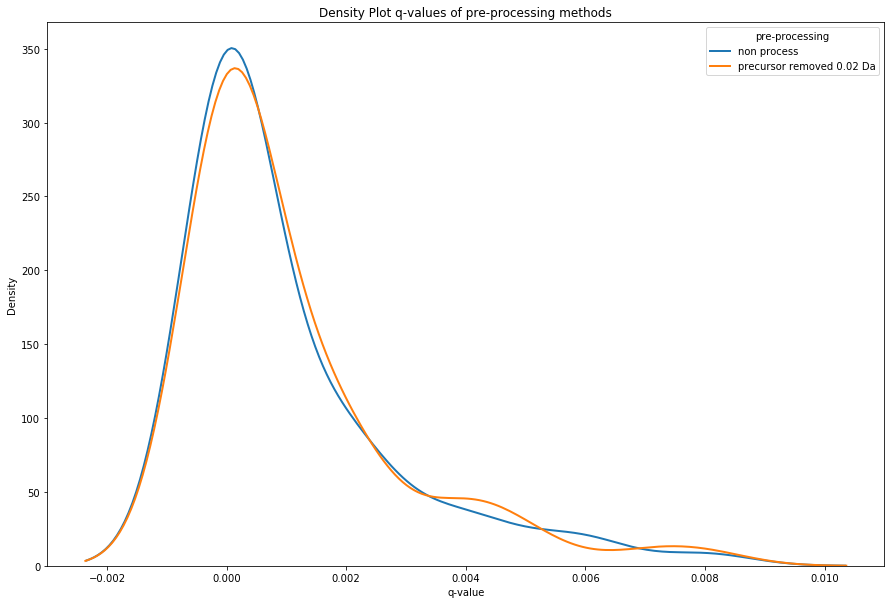

In high subset 3 non-processed there are this number of significant peptide identifications: 63
In high subset 3 with precursor removed 0.02 Da there are this number of significant peptide identifications: 63


In [156]:
# High_subset 3
df = df_density_format_subsets(lists, methods, 2)
plt.figure(figsize=(15,10))
plot_q_values_densityplots(df, methods)
print("In high subset 3 non-processed there are this number of significant peptide identifications:", len(list_PSMscores_TICsubset_non_process[2]))
print("In high subset 3 with precursor removed 0.02 Da there are this number of significant peptide identifications:", len(list_PSMscores_TICsubset_002[2]))

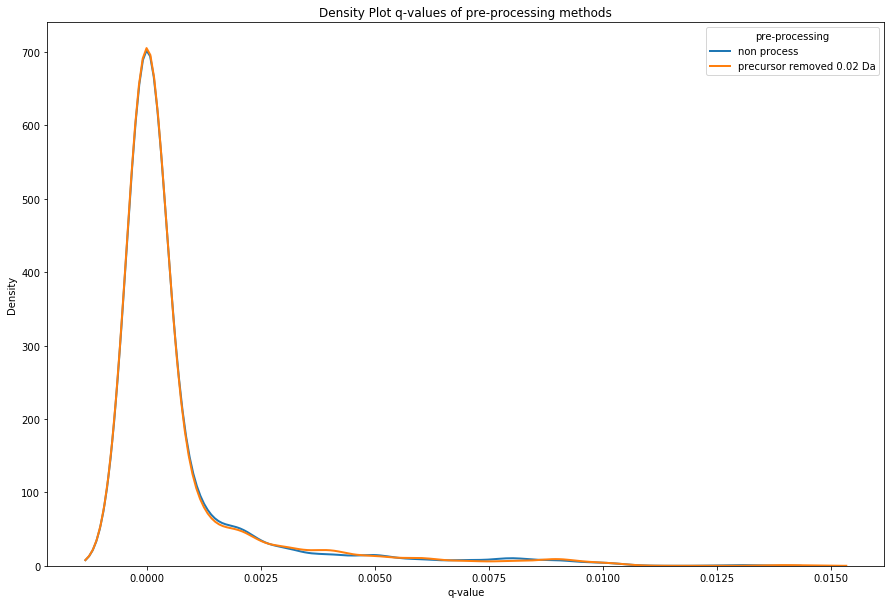

In high subset 2 non-processed there are this number of significant peptide identifications: 963
In high subset 2 with precursor removed 0.02 Da there are this number of significant peptide identifications: 961


In [157]:
# High_subset 2
df = df_density_format_subsets(lists, methods, 1)
plt.figure(figsize=(15,10))
plot_q_values_densityplots(df, methods)
print("In high subset 2 non-processed there are this number of significant peptide identifications:", len(list_PSMscores_TICsubset_non_process[1]))
print("In high subset 2 with precursor removed 0.02 Da there are this number of significant peptide identifications:", len(list_PSMscores_TICsubset_002[1]))

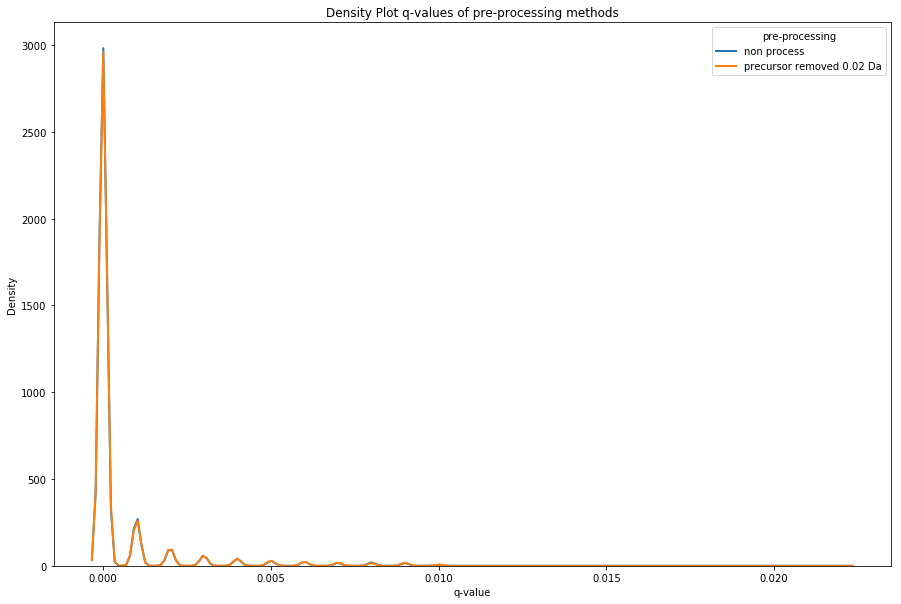

In high subset 1 non-processed there are this number of significant peptide identifications: 288411
In high subset 1 with precursor removed 0.02 Da there are this number of significant peptide identifications: 288486


In [158]:
# High_subset 1
df = df_density_format_subsets(lists, methods, 0)
plt.figure(figsize=(15,10))
plot_q_values_densityplots(df, methods)
print("In high subset 1 non-processed there are this number of significant peptide identifications:", len(list_PSMscores_TICsubset_non_process[0]))
print("In high subset 1 with precursor removed 0.02 Da there are this number of significant peptide identifications:", len(list_PSMscores_TICsubset_002[0]))

In [159]:
def get_num_spectra_per_subset(subsets_df, subset):
    total_spec_sub = 0
    for index, row in subsets_df.iterrows():
        for spectrum in row[subset]:
                total_spec_sub += 1
    return total_spec_sub

In [160]:
get_num_spectra_per_subset(subsets_df, "subset1"), get_num_spectra_per_subset(subsets_df, "subset2"), get_num_spectra_per_subset(subsets_df, "subset3"), get_num_spectra_per_subset(subsets_df, "subset4")

(404046, 2448, 337, 82)

In [161]:
len(list_PSMscores_TICsubset_non_process[0]), len(list_PSMscores_TICsubset_non_process[1]), len(list_PSMscores_TICsubset_non_process[2]), len(list_PSMscores_TICsubset_non_process[3])

(288411, 963, 63, 1)

In [162]:
len(list_PSMscores_TICsubset_002[0]), len(list_PSMscores_TICsubset_002[1]), len(list_PSMscores_TICsubset_002[2]), len(list_PSMscores_TICsubset_002[3])

(288486, 961, 63, 1)

In [163]:
# Percentage of identifications per subset with non-processed data
for i, element in enumerate([288411, 963, 63, 1]):
    print(element/[404046, 2448, 337, 82][i]*100)

71.3807338768358
39.338235294117645
18.694362017804153
1.2195121951219512


In [164]:
# Percentage of identifications per subset with precursor removed at 0.02 Da
for i, element in enumerate([288486, 961, 63, 1]):
    print(element/[404046, 2448, 337, 82][i]*100)

71.39929611974874
39.256535947712415
18.694362017804153
1.2195121951219512
